In [4]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from skimage.color import rgb2lab
import random


# With Embedding

In [5]:
image = Image.open('/home/yec23006/projects/research/KneeGrowthPlate/Embedding/image/png/CCC_K10_F1_L2/sfo.png').convert('RGB')
image_np = np.array(image)

image_pixels = image_np.reshape(-1, 3) / 255.0
image_pixels_tensor = torch.tensor(image_pixels, dtype=torch.float32)

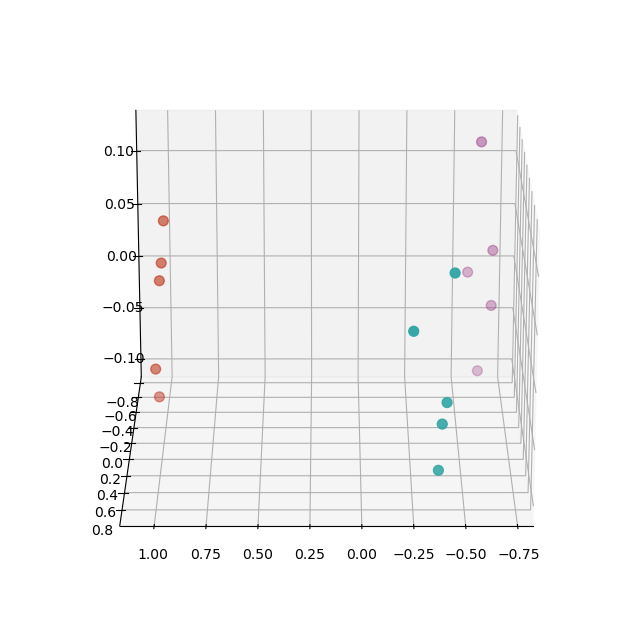

In [23]:
random.seed(42)
np.random.seed(42)

# Convert group colors to tensors and normalize them
colors = [torch.tensor(group, dtype = torch.float32)/255.0 for group in [
    np.array([[156,133,169], [134,98,131], [153,57,132], [236,206,226], [112,124,165]]),  # Purple
    np.array([[239,154,54], [189,50,25], [239,174,83], [169,75,36], [241,44,23]]),  # Brown
    np.array([[107,231,231], [55,167,167], [32,165,152], [187,237,239], [132,222,230]])  # Mint
]]


# Flatten and store cluster labels
X = torch.cat(colors)
y = torch.cat([torch.full((len(group),), i) for i, group in enumerate(colors)])

# Normalize to unit sphere
X = X / torch.norm(X, dim=1, keepdim=True)

# Learnable CNN-based embeddings
embedding_dim = 5
class ClusterEmbedding(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_clusters):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, embedding_dim)
        )
        self.cluster_centers = nn.Parameter(torch.randn(num_clusters, embedding_dim))

    def forward(self, x):
        x = self.fc(x)
        x = x / torch.norm(x, dim=1, keepdim=True)  # Normalize embeddings
        return x

def contrastive_loss(embeddings, labels, cluster_centers, margin=3.0):  # Increased margin
    intra_loss = 0  
    inter_loss = 0  
    num_clusters = cluster_centers.shape[0]
    
    # Intra-cluster compactness: Pull embeddings closer to their assigned cluster center
    for i in range(num_clusters):
        cluster_embeds = embeddings[labels == i]
        if cluster_embeds.shape[0] > 1:
            intra_loss += torch.mean(1 - torch.cosine_similarity(cluster_embeds, cluster_centers[i].unsqueeze(0)))

    # Inter-cluster separation: Push clusters apart based on similarity
    num_pairs = 0
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                similarity = torch.cosine_similarity(cluster_centers[i].unsqueeze(0), cluster_centers[j].unsqueeze(0))
                distance_penalty = torch.exp(-torch.norm(cluster_centers[i] - cluster_centers[j]))  # Exponential scaling
                inter_loss += torch.clamp(margin - similarity, min=0) * distance_penalty  # Stronger push

                num_pairs += 1

    inter_loss /= num_pairs  # Normalize
    return intra_loss + 3.0 * inter_loss  # Increase weight of inter-cluster loss


model = ClusterEmbedding(input_dim=3, embedding_dim=embedding_dim, num_clusters=len(colors))
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    embeddings = model(X)
    loss = contrastive_loss(embeddings, y, model.cluster_centers) 
    loss.backward()
    optimizer.step()

# Visualize embeddings
# Define the original colors in RGB (normalized to [0,1])
cluster_colors = np.array([
    [153, 57, 132],   # Purple
    [189, 50, 25],  # Brown
    [55, 167, 167],   # Mint
]) / 255.0  # Normalize to [0,1]

# Convert cluster labels to corresponding colors
point_colors = np.array([cluster_colors[label] for label in y.numpy()])

pca = PCA(n_components=3)
projected_embeddings = pca.fit_transform(model(X).detach().numpy())

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], projected_embeddings[:, 2], color=point_colors, s=50)
# plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], projected_embeddings[:, 2], color=point_colors, s=50)
ax.view_init(elev=20, azim=90)

plt.show()



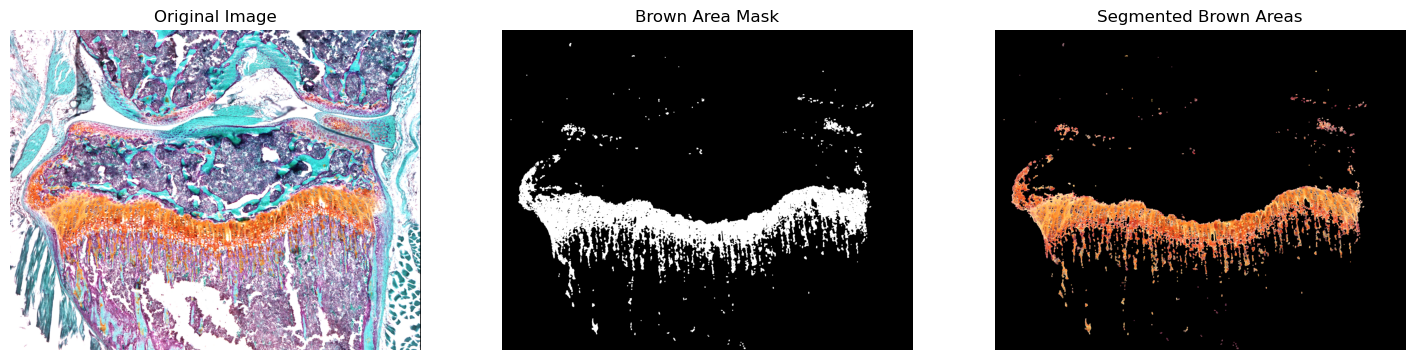

In [24]:
# Project image pixels into the trained embedding space
with torch.no_grad():
    pixel_embeddings = model(image_pixels_tensor)

# Extract the embedding of the brown cluster from the trained model
brown_cluster_idx = 1  # Adjust if needed
brown_center = model.cluster_centers[brown_cluster_idx]

# Compute cosine similarity between each pixel and brown cluster center
cosine_similarities = torch.cosine_similarity(pixel_embeddings, brown_center.unsqueeze(0), dim=1)

# Create a mask based on similarity threshold
brown_threshold = 0.9  # Adjust as needed
brown_mask = (cosine_similarities > brown_threshold).numpy().reshape(image_np.shape[:2])

# Convert mask to binary image and apply morphological processing
brown_mask_binary = (brown_mask * 255).astype(np.uint8)
kernel = np.ones((5, 5), np.uint8)
brown_mask_denoised = cv2.morphologyEx(brown_mask_binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Apply mask to extract brown areas
segmented_brown = np.zeros_like(image_np)
segmented_brown[brown_mask_denoised == 255] = image_np[brown_mask_denoised == 255]

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(brown_mask_denoised, cmap="gray")
axes[1].set_title("Brown Area Mask")
axes[1].axis("off")

axes[2].imshow(segmented_brown)
axes[2].set_title("Segmented Brown Areas")
axes[2].axis("off")

plt.show()


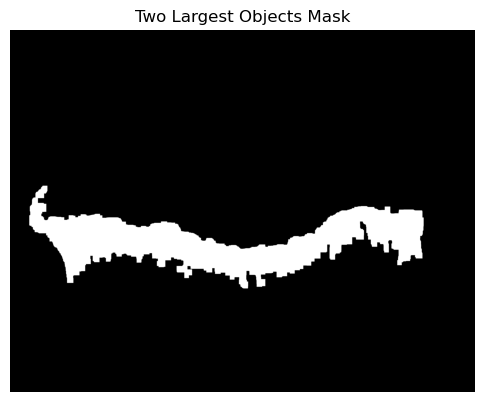

True

In [42]:
from scipy.ndimage import binary_fill_holes, label

# Apply morphological operations to clean up the segmentation mask
kernel = np.ones((5,5), np.uint8)

# Perform morphological closing to fill small holes
closed_mask = cv2.morphologyEx(brown_mask_denoised, cv2.MORPH_CLOSE, kernel, iterations=5)

# Perform morphological opening to remove noise
morph_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, kernel, iterations=10)
filled_mask = binary_fill_holes(morph_mask).astype(np.uint8)
labeled_mask, num_features = label(filled_mask)

unique, counts = np.unique(labeled_mask, return_counts=True)
sorted_indices = np.argsort(counts)[::-1]

if len(sorted_indices) > 2:
    largest_label = unique[sorted_indices[1]]

    # Create a mask with only the two largest objects
    final_selected_mask = (labeled_mask == largest_label).astype(np.uint8) * 255
else:
    final_selected_mask = filled_mask * 255

plt.figure(figsize=(6, 6))
plt.imshow(final_selected_mask, cmap='gray')
plt.title("Two Largest Objects Mask")
plt.axis("off")
plt.show()


# Save the refined mask
refined_mask_path = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/segmentation_mask2.png"
cv2.imwrite(refined_mask_path, final_selected_mask)

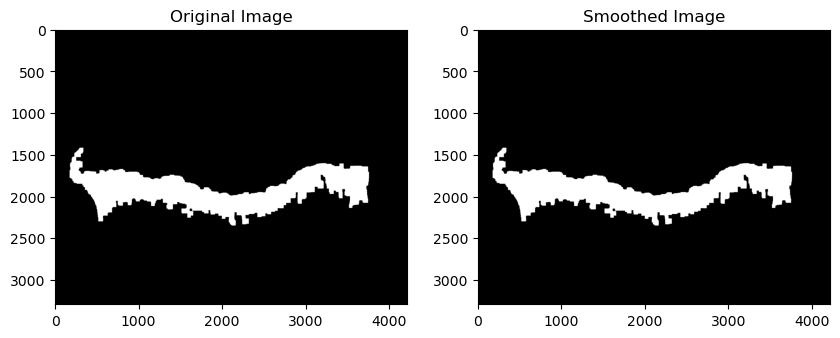

False

In [43]:
kernel = np.ones((5,5), np.uint8)
image_closed = cv2.morphologyEx(final_selected_mask, cv2.MORPH_CLOSE, kernel)

# Apply Gaussian Blur to further smoothen the edges
image_blurred = cv2.GaussianBlur(image_closed, (5,5), 0)

# Convert back to binary
_, image_smoothed = cv2.threshold(image_blurred, 127, 255, cv2.THRESH_BINARY)

# Show the result
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(final_selected_mask, cmap='gray')

plt.subplot(1,2,2)
plt.title("Smoothed Image")
plt.imshow(image_smoothed, cmap='gray')

plt.show()

refined_mask_path = "/home/yec23006/projects/research/KneeGrowthPlate/results/embedding/smoothed_segmentation_mask2.png"
cv2.imwrite(refined_mask_path, image_smoothed)

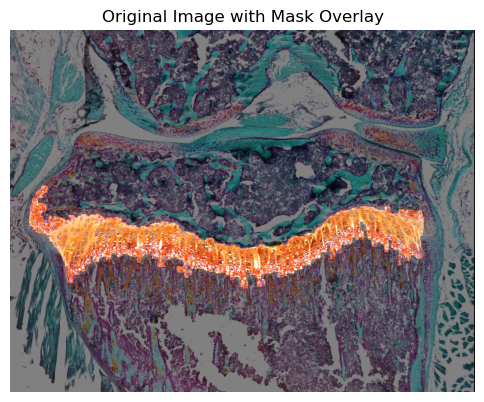

In [44]:
mask_bgr = cv2.cvtColor(image_smoothed, cv2.COLOR_GRAY2BGR)


mask_rgba = np.zeros((mask_bgr.shape[0], mask_bgr.shape[1], 4), dtype=np.uint8)
mask_rgba[:, :, :3] = mask_bgr  
mask_rgba[:, :, 3] = (image_smoothed == 0) * int(0.5 * 255)  # Set alpha based on mask

image_pil = Image.fromarray(image_np)
mask_pil = Image.fromarray(mask_rgba, mode="RGBA")

overlay = Image.alpha_composite(image_pil.convert("RGBA"), mask_pil)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis('off')
plt.title("Original Image with Mask Overlay")
plt.show()

path2save = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/overlay2.png"
overlay.save(path2save)

In [ ]:
overlay_lineOn = overlay + 

# Patch classification

In [46]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset

In [45]:
path2mask = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/segmentation_mask2.png'
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/image/png/CCC_K10_F1_L2/sfo.png'

image = Image.open(path2img).convert('RGB')
image_np = np.array(image)

mask = Image.open(path2mask).convert('L')
mask_np = np.array(mask)

print(image_np.shape, mask_np.shape)

(3292, 4223, 3) (3292, 4223)


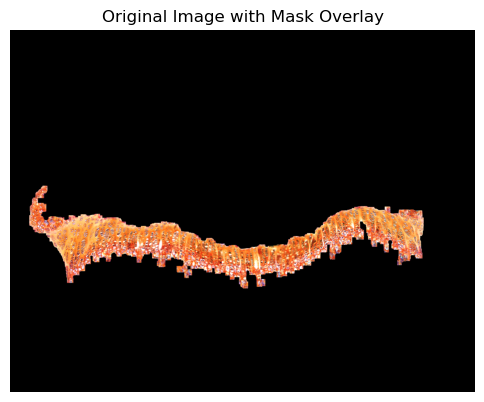

In [47]:
overlap = image_np * (mask_np[:, :, np.newaxis] // 255)

plt.figure(figsize=(6,6))
plt.imshow(overlap)
plt.axis('off')
plt.title("Original Image with Mask Overlay")
plt.show()

overlap_img = Image.fromarray(overlap)
path2save = "/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/overlay_extraction2.png"
overlap_img.save(path2save)

Epoch [1/10], Loss: 0.0000
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


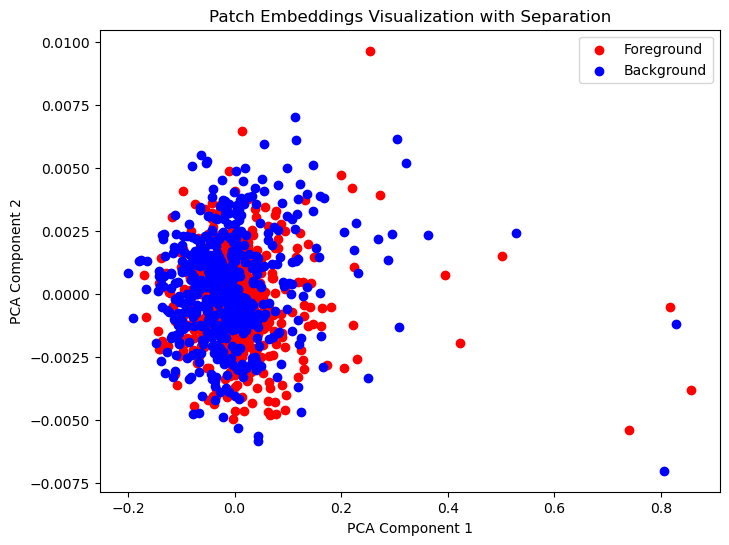

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset

# Load images in RGB scale
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg'
path2platemask = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/embedding/growthplate_mask.png'
path2columnar = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/embedding/columnar_mask.png'

image = cv2.imread(path2img, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
platemask = cv2.imread(path2platemask, cv2.IMREAD_GRAYSCALE)
columnarmask = cv2.imread(path2columnar, cv2.IMREAD_GRAYSCALE)

# Define patch extraction function for RGB images
def extract_patches(image, platemask, columnarmask, patch_size=16, num_patches=1000, foreground=True):
    h, w, _ = image.shape
    patches = []

    selected_mask = columnarmask if foreground else (platemask - columnarmask)
    selected_mask = np.clip(selected_mask, 0, 255)

    valid_points = np.argwhere(selected_mask > 128)

    for _ in range(num_patches):
        if len(valid_points) == 0:
            break
        y, x = valid_points[np.random.randint(0, len(valid_points))]
        x = max(0, min(x, w - patch_size))
        y = max(0, min(y, h - patch_size))
        patch = image[y:y+patch_size, x:x+patch_size, :]
        patches.append(patch)
    
    return np.array(patches)

# Extract patches
patch_size = 64
num_patches = 500
foreground_patches = extract_patches(image, platemask, columnarmask, patch_size, num_patches, foreground=True)
background_patches = extract_patches(image, platemask, columnarmask, patch_size, num_patches, foreground=False)

# Normalize and reshape patches
all_patches = np.vstack((foreground_patches, background_patches))
labels = np.array([1] * num_patches + [0] * num_patches)
all_patches = all_patches.astype(np.float32) / 255.0
all_patches = np.transpose(all_patches, (0, 3, 1, 2))  # Convert to (batch, channels, height, width)

# Define a simple embedding network
class PatchEmbeddingNet(nn.Module):
    def __init__(self):
        super(PatchEmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * (patch_size // 4) * (patch_size // 4), 128)  # Adjusted to match conv output size
        self.fc2 = nn.Linear(128, 2)  # 2D embedding space for separation
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.nn.functional.adaptive_avg_pool2d(x, (patch_size // 4, patch_size // 4))  # Ensure fixed-size flattening
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the embedding model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatchEmbeddingNet().to(device)
criterion = nn.CosineEmbeddingLoss(margin=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare data
data_tensor = torch.tensor(all_patches).to(device)
label_tensor = torch.tensor(labels * 2 - 1, dtype=torch.float32).to(device)  # Convert labels to [-1, 1] for CosineEmbeddingLoss

data_loader = DataLoader(TensorDataset(data_tensor, label_tensor), batch_size=32, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch_data, batch_labels in data_loader:
        optimizer.zero_grad()
        embeddings = model(batch_data)
        target_embeddings = torch.ones_like(embeddings) * batch_labels.view(-1, 1).to(device)  # Separate classes
        loss = criterion(embeddings, target_embeddings, batch_labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Extract embeddings
with torch.no_grad():
    embeddings = model(data_tensor).cpu().numpy()

# Apply PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:num_patches, 0], reduced_embeddings[:num_patches, 1], c='r', label='Foreground')
plt.scatter(reduced_embeddings[num_patches:, 0], reduced_embeddings[num_patches:, 1], c='b', label='Background')
plt.legend()
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Patch Embeddings Visualization with Separation")
plt.show()


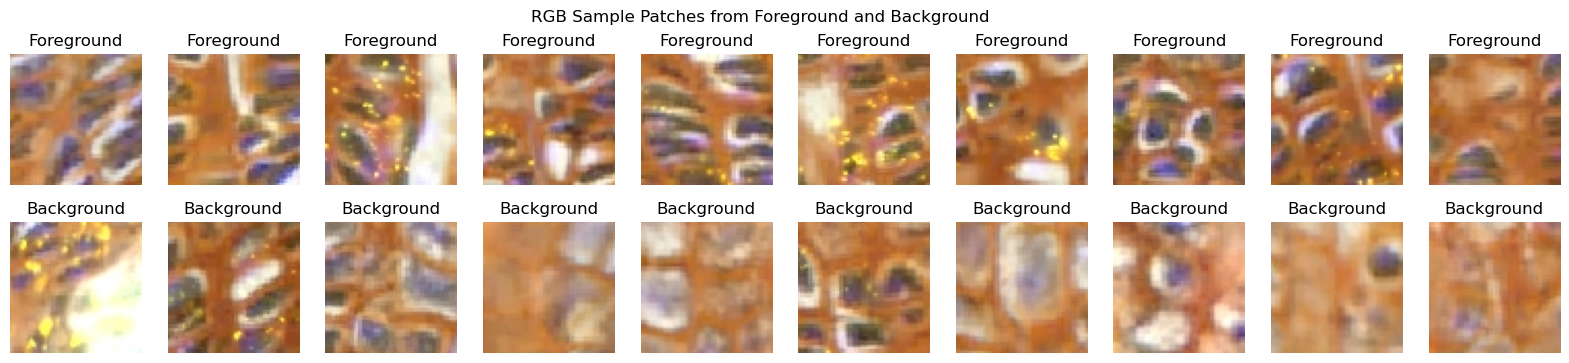

In [22]:
# Load images in RGB scale
image_rgb = cv2.imread(path2img, cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Define patch extraction function for RGB images
def extract_patches_rgb(image, mask, platemask_columnarmask, columnarmask, patch_size=32, num_patches=10, foreground=True):
    h, w, _ = image.shape
    patches = []
    
    # Select appropriate mask for extraction
    selected_mask = columnarmask if foreground else (platemask_columnarmask - columnarmask)
    selected_mask = np.clip(selected_mask, 0, 255)  # Ensure valid mask range
    
    # Extract patch locations
    valid_points = np.argwhere(selected_mask > 128)
    
    for _ in range(num_patches):
        if len(valid_points) == 0:
            break
        y, x = valid_points[np.random.randint(0, len(valid_points))]
        x = max(0, min(x, w - patch_size))
        y = max(0, min(y, h - patch_size))
        patch = image[y:y+patch_size, x:x+patch_size, :]
        patches.append(patch)
    
    return np.array(patches)

# Extract 10 patches for visualization
foreground_patches_rgb = extract_patches_rgb(image_rgb, mask, platemask, columnarmask, 64, 10, foreground=True)
background_patches_rgb = extract_patches_rgb(image_rgb, mask, platemask, columnarmask, 64, 10, foreground=False)

# Create figure for visualization
num_foreground = len(foreground_patches_rgb)
num_background = len(background_patches_rgb)
num_visualize = min(num_patches, num_foreground, num_background)

fig, axes = plt.subplots(2, num_visualize, figsize=(num_visualize * 2, 4))

for i in range(num_visualize):
    # Foreground patches
    axes[0, i].imshow(foreground_patches_rgb[i])
    axes[0, i].axis("off")
    axes[0, i].set_title("Foreground")

    # Background patches
    axes[1, i].imshow(background_patches_rgb[i])
    axes[1, i].axis("off")
    axes[1, i].set_title("Background")

plt.suptitle("RGB Sample Patches from Foreground and Background")
plt.show()


Epoch [1/10], Loss: 0.5703
Epoch [2/10], Loss: 0.6639
Epoch [3/10], Loss: 0.4955
Epoch [4/10], Loss: 1.5771
Epoch [5/10], Loss: 1.5572
Epoch [6/10], Loss: 0.6556
Epoch [7/10], Loss: 0.8168
Epoch [8/10], Loss: 1.6244
Epoch [9/10], Loss: 1.1343
Epoch [10/10], Loss: 0.7327


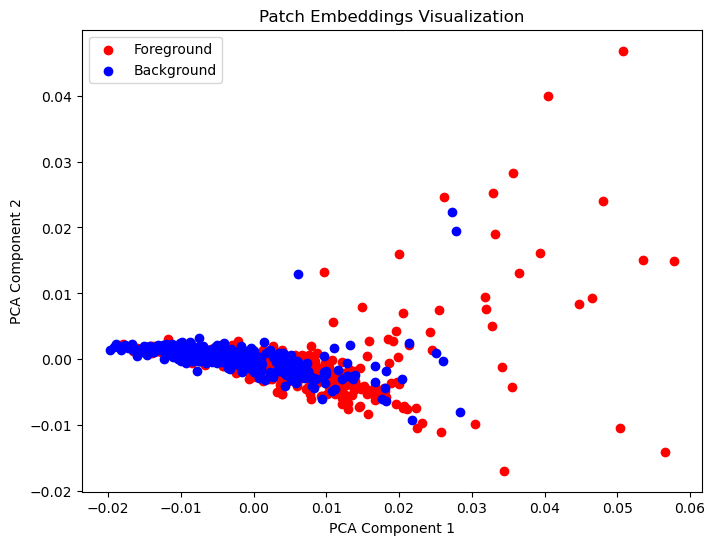

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset

# Load images in RGB scale
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg'
path2platemask = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/embedding/growthplate_mask.png'
path2columnar = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/embedding/columnar_mask.png'

image = cv2.imread(path2img, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
platemask = cv2.imread(path2platemask, cv2.IMREAD_GRAYSCALE)
columnarmask = cv2.imread(path2columnar, cv2.IMREAD_GRAYSCALE)

# Define patch extraction function for RGB images
def extract_patches(image, platemask, columnarmask, patch_size=16, num_patches=1000, foreground=True):
    h, w, _ = image.shape
    patches = []

    selected_mask = columnarmask if foreground else (platemask - columnarmask)
    selected_mask = np.clip(selected_mask, 0, 255)

    valid_points = np.argwhere(selected_mask > 128)

    for _ in range(num_patches):
        if len(valid_points) == 0:
            break
        y, x = valid_points[np.random.randint(0, len(valid_points))]
        x = max(0, min(x, w - patch_size))
        y = max(0, min(y, h - patch_size))
        patch = image[y:y+patch_size, x:x+patch_size, :]
        patches.append(patch)
    
    return np.array(patches)

# Extract patches
patch_size = 64
num_patches = 500
foreground_patches = extract_patches(image, platemask, columnarmask, patch_size, num_patches, foreground=True)
background_patches = extract_patches(image, platemask, columnarmask, patch_size, num_patches, foreground=False)

# Normalize and reshape patches
all_patches = np.vstack((foreground_patches, background_patches))
labels = np.array([1] * num_patches + [0] * num_patches)
all_patches = all_patches.astype(np.float32) / 255.0
all_patches = np.transpose(all_patches, (0, 3, 1, 2))  # Convert to (batch, channels, height, width)

# Define a simple embedding network
class PatchEmbeddingNet(nn.Module):
    def __init__(self):
        super(PatchEmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * patch_size * patch_size, 128)
        self.fc2 = nn.Linear(128, 2)  # 2D embedding space
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the embedding model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatchEmbeddingNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare data
data_tensor = torch.tensor(all_patches).to(device)
label_tensor = torch.tensor(labels, dtype=torch.float32).to(device)
data_loader = DataLoader(TensorDataset(data_tensor, label_tensor), batch_size=32, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch_data, _ in data_loader:
        optimizer.zero_grad()
        embeddings = model(batch_data)
        loss = criterion(embeddings, torch.randn_like(embeddings).to(device))
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Extract embeddings
with torch.no_grad():
    embeddings = model(data_tensor).cpu().numpy()

# Apply PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:num_patches, 0], reduced_embeddings[:num_patches, 1], c='r', label='Foreground')
plt.scatter(reduced_embeddings[num_patches:, 0], reduced_embeddings[num_patches:, 1], c='b', label='Background')
plt.legend()
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Patch Embeddings Visualization")
plt.show()
